In [1]:
from pymongo import MongoClient
from keras.models import Sequential
from keras.layers import Input, Dense, GRU, Embedding, CuDNNGRU
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from scipy.ndimage.filters import maximum_filter1d, minimum_filter1d
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import time
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

/home/amit/workspace/learning_dp/.venv/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Depracated

In [2]:
def max_filter1d_valid(a, W):
    hW = (W-1)//2 # Half window size
    return maximum_filter1d(a,size=W, mode="constant")[hW:-hW]

def min_filter1d_valid(a, W):
    hW = (W-1)//2 # Half window size
    return minimum_filter1d(a,size=W)[hW:-hW]

Loading the data from database. Make sure that the mongod deamon is running

In [3]:
url = '127.0.0.1'
client = MongoClient(url, ssl=False)
connection = client['binance_coins']
coin = "ETH"
symbol = "{}BTC".format(coin)
coins_collection = connection[symbol]
res = list(connection[symbol].find())
print("{} samples where the last is from {}".format(len(res), time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(res[-1]["Close time"]/1000.))))


87424 samples where the last is from 2018-05-13 20:19:59


Arranging the data.
Each data point gets the next 40 samples (5 minutes * 40 = 200 minutes -> 3 hours data).

spliting the data to 70/30 train/test sets

0 High
1 Open
2 Taker buy base asset volume
3 Volume
4 Number of trades
5 Low
6 Quote asset volume
7 Close
8 Taker buy quote asset volume
('Min:', 0.0)
('Max:', 17793.188)
('Min:', 0.0)
('Max:', 1.0000000000000002)
(61168, 9)
(26216, 9)
(61168, 40)
(26216, 40)


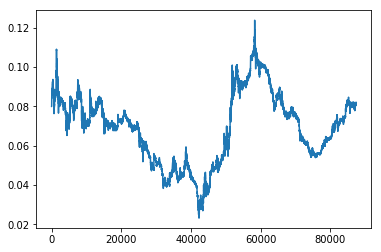

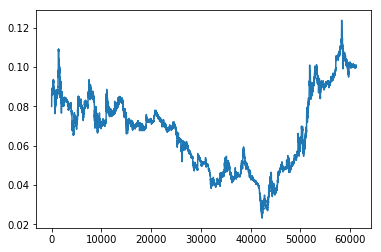

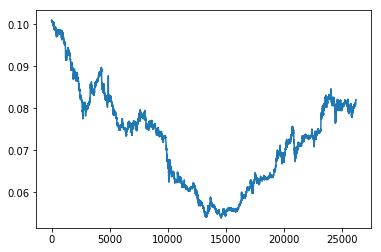

In [4]:
highs = []
lows = []
keys_list = res[0].keys()
keys_list.remove('_id')
keys_list.remove('Close time')
keys_list.remove('Open time')
keys_list.remove('Ignore')
x_data = []
for r in res:
    x = []
    for k in keys_list:
        x.append(r[k])
    x_data.append(x)

x_data = np.array(x_data)

prediction_period_minutes = 24 * 60

for i in range(len(keys_list)):
    print i, keys_list[i]

# x_max_data = max_filter1d_valid(x_data[:, 0], prediction_period_minutes)
# x_min_data = min_filter1d_valid(x_data[:, 6], prediction_period_minutes)


y_data = []
for i in range(len(x_data)-40):
    temp = []
    for x in range(40):
        temp.append(x_data[i+x][1])
        
    y_data.append(temp)

y_data = np.array(y_data)
x_data = x_data[:len(y_data)]


# X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)

num_samples = x_data.shape[0]
X_train = x_data[:int(0.7*num_samples), :]
X_test = x_data[int(0.7*num_samples):, :]

y_train = y_data[:int(0.7*num_samples), :]
y_test = y_data[int(0.7*num_samples):, :]

plt.plot(x_data[:,0])
plt.figure()
plt.plot(X_train[:,0])
plt.figure()
plt.plot(X_test[:,0])

print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(X_train)
x_test_scaled = x_scaler.transform(X_test)

print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

print x_train_scaled.shape
print x_test_scaled.shape
print y_train_scaled.shape
print y_test_scaled.shape

num_train = x_train_scaled.shape[0]
num_test = x_test_scaled.shape[0]
num_y_signals = y_train_scaled.shape[1]
num_x_signals = x_train_scaled.shape[1]

validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [5]:
batch_size = 256
sequence_length = 1000

def batch_generator(batch_size, sequence_length, X, Y):
    """
    Generator function for creating random batches of training-data.
    """
    num_samples = X.shape[0]
    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, X.shape[1])
        x_batch = np.zeros(shape=x_shape, dtype=np.float32)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, Y.shape[1])
        y_batch = np.zeros(shape=y_shape, dtype=np.float32)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_samples - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = X[idx:idx+sequence_length]
            y_batch[i] = Y[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [6]:

generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length, X=x_train_scaled, Y=y_train_scaled)

In [7]:
x_batch, y_batch = next(generator)
print(x_batch.shape)
print(y_batch.shape)

(256, 1000, 9)
(256, 1000, 40)


model declaration:

In [9]:
model = Sequential()

model.add(CuDNNGRU(units=512, return_sequences=True, input_shape=(None, num_x_signals,)))
model.add(Dense(num_y_signals, activation='sigmoid'))



In [10]:
warmup_steps = 50

def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [11]:
optimizer = RMSprop(lr=1e-3)

In [12]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, None, 512)         803328    
_________________________________________________________________
dense_1 (Dense)              (None, None, 40)          20520     
Total params: 823,848
Trainable params: 823,848
Non-trainable params: 0
_________________________________________________________________


In [13]:
path_checkpoint = '23_checkpoint.keras'

callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)


callback_early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
callback_tensorboard = TensorBoard(log_dir='./23_logs/', histogram_freq=0, write_graph=False)


callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

To retrain the model, set condition to True.

In [14]:
%%time
if False:
    model.fit_generator(generator=generator,
                        epochs=20,
                        steps_per_epoch=100,
                        validation_data=validation_data,
                        callbacks=callbacks)

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 8.11 µs


In [15]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [16]:
result = model.evaluate(x=np.expand_dims(X_test, axis=0),
                        y=np.expand_dims(y_test, axis=0))

1/1 [==============================] - 1s 1s/step


('loss (test-set):', 0.002997110364958644)
(26216,)


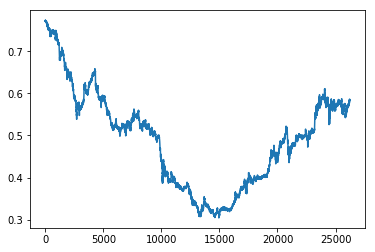

In [17]:
print("loss (test-set):", result)
print (x_test_scaled[:,0].shape)
plt.plot(x_test_scaled[:,1])

In [18]:
x = np.expand_dims(x_data[:512] , axis=0)
print (x.shape)
y_pred = model.predict(x)
print(y_pred.shape)

(1, 512, 9)
(1, 512, 40)


Ploting predicted VS actual

In [56]:
def plot_comparison(start_idx, length=100, train=False):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
        print "train data"
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
        print "test data"
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx,:]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)
    
    
    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    print (y_pred.shape)
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    print (y_true.shape)
    print (y_pred_rescaled.shape)
    for i in range(100):
        plt.figure()
        plt.plot(y_true[0,:])
        plt.plot(y_pred_rescaled[0,:])
    
        
    
#     # For each output-signal.
#     for signal in range(len(target_names)):
#         # Get the output-signal predicted by the model.
#         signal_pred = y_pred_rescaled[:, signal]
        
#         # Get the true output-signal from the data-set.
#         signal_true = y_true[:, signal]

#         # Make the plotting-canvas bigger.
#         plt.figure(figsize=(15,5))
        
#         # Plot and compare the two signals.
#         plt.plot(signal_true, label='true')
#         plt.plot(signal_pred, label='pred')
        
#         # Plot grey box for warmup-period.
#         p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
#         # Plot labels etc.
#         plt.ylabel(target_names[signal])
#         plt.legend()
#         plt.show()

test data
(1, 1000, 40)
(1000, 40)
(1000, 40)


/home/amit/workspace/learning_dp/.venv/local/lib/python2.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


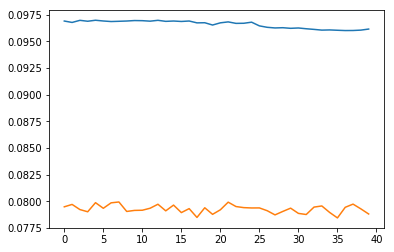

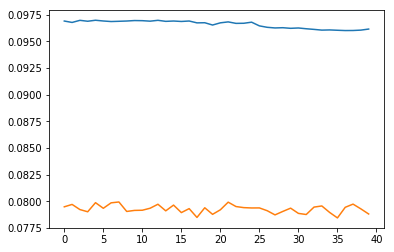

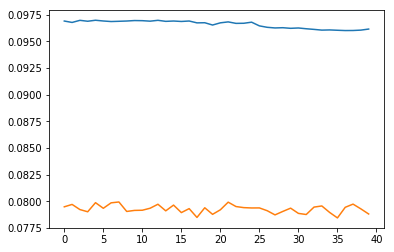

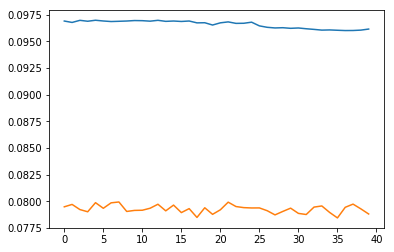

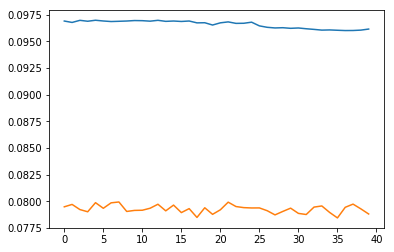

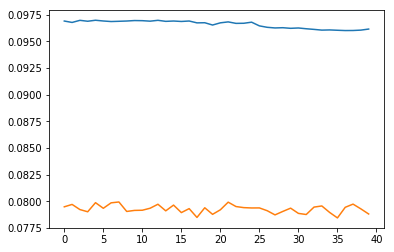

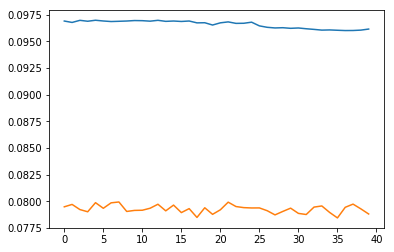

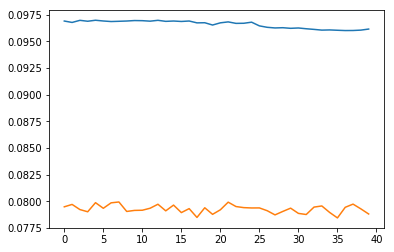

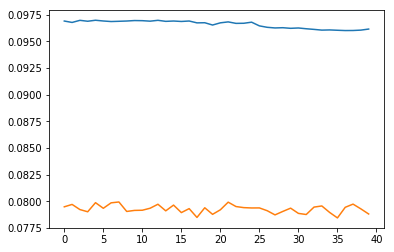

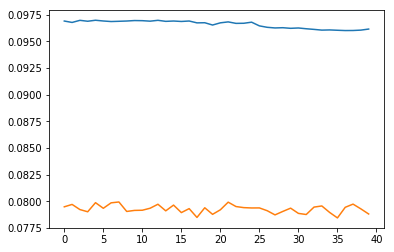

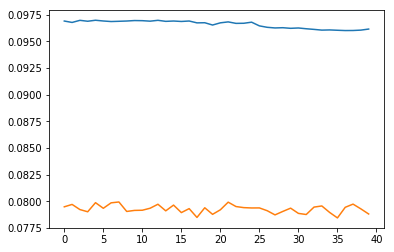

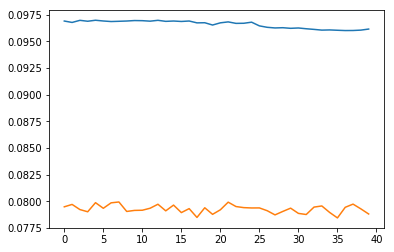

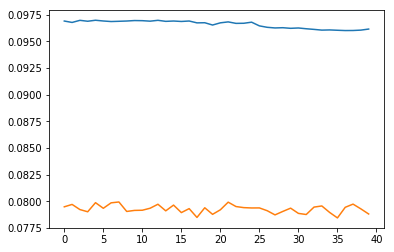

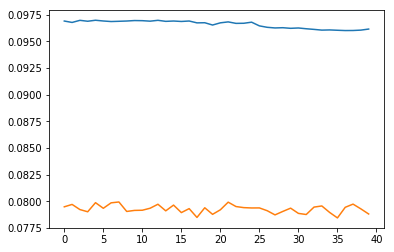

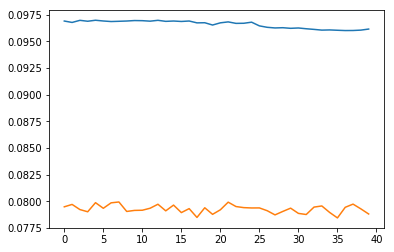

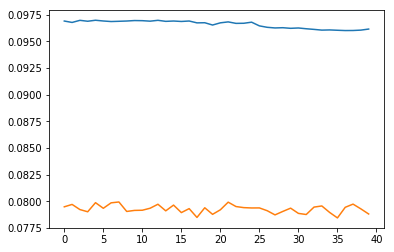

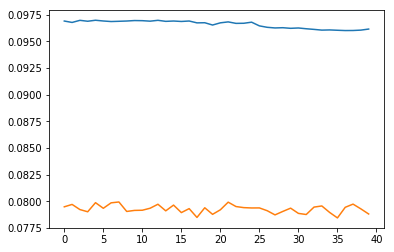

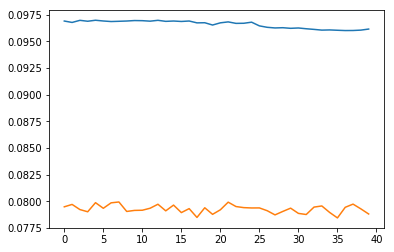

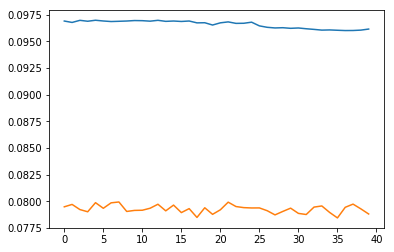

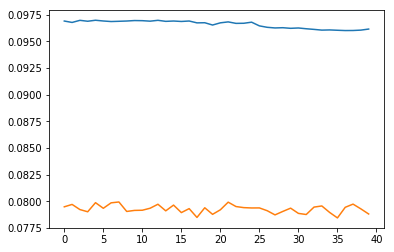

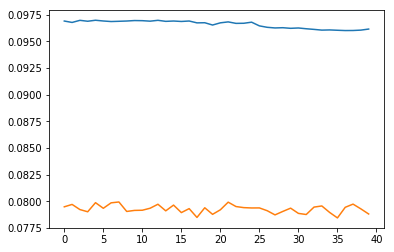

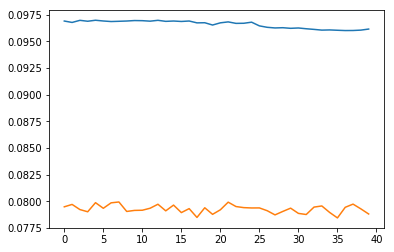

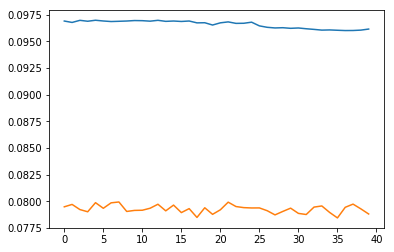

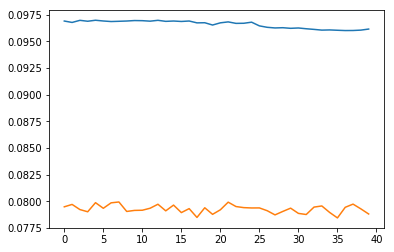

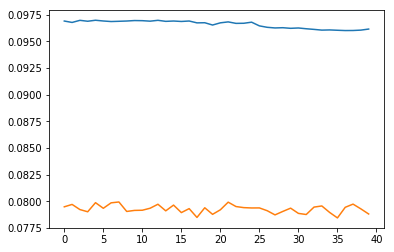

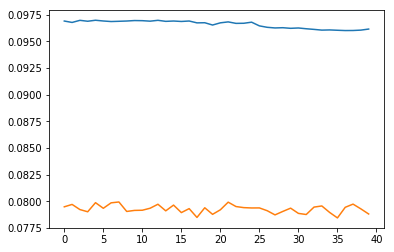

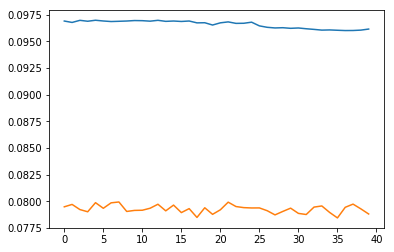

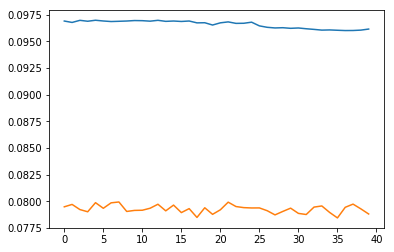

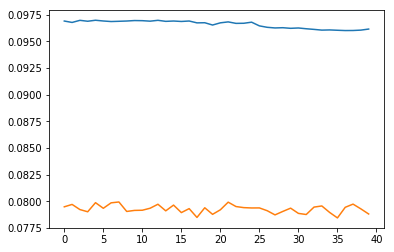

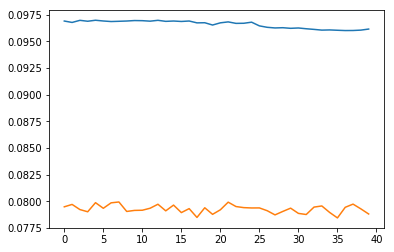

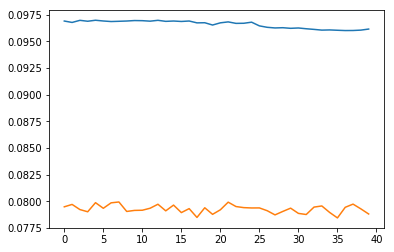

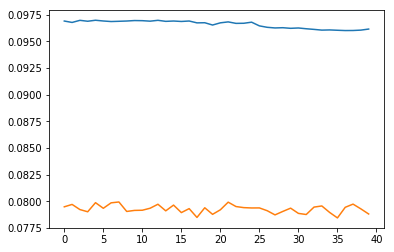

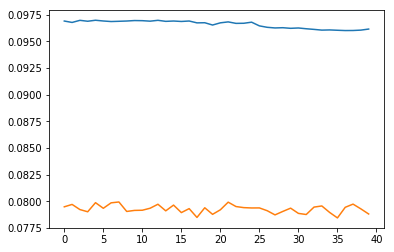

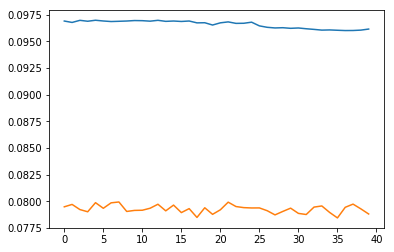

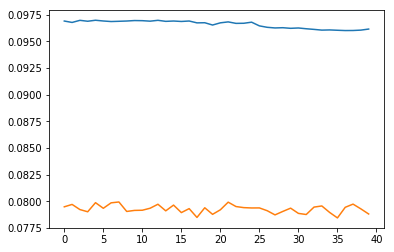

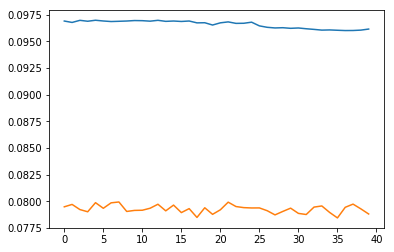

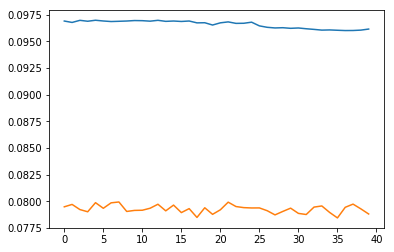

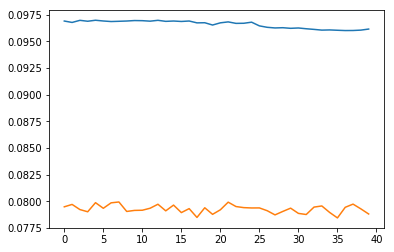

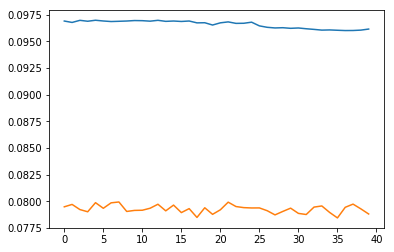

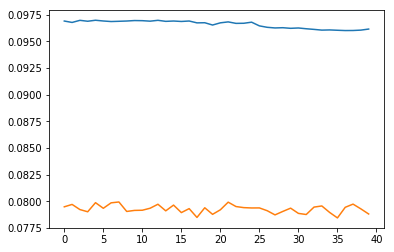

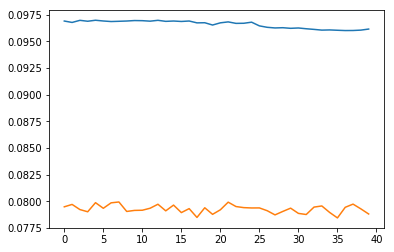

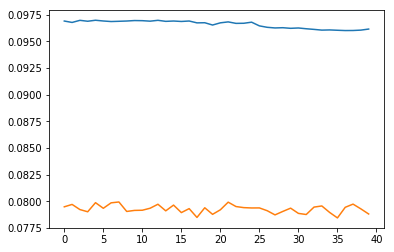

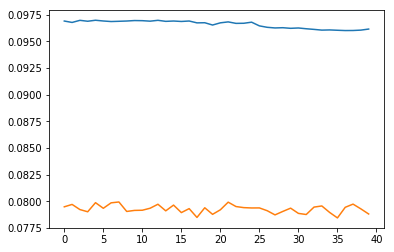

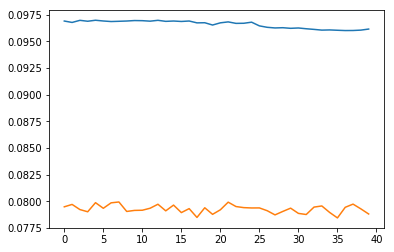

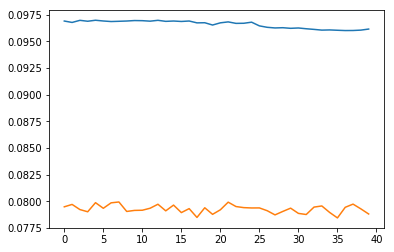

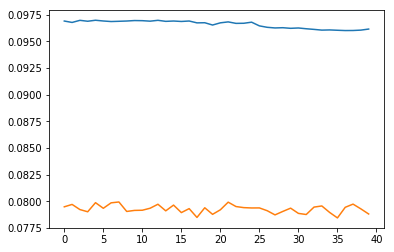

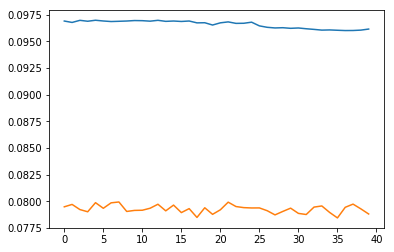

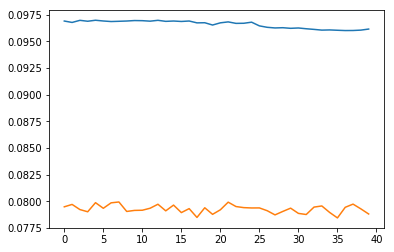

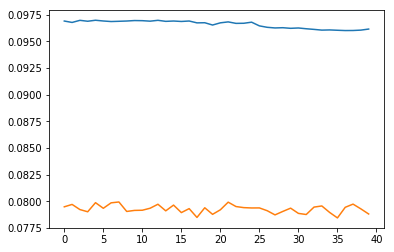

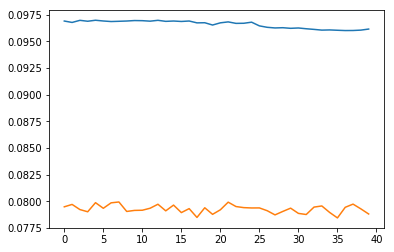

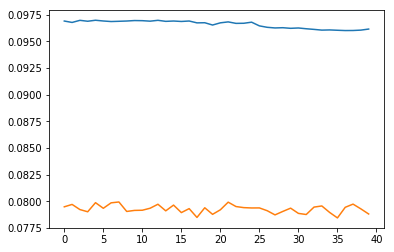

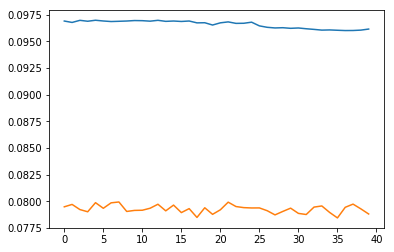

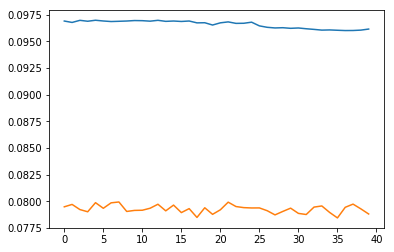

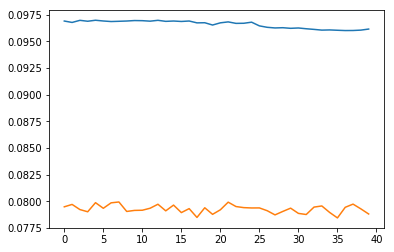

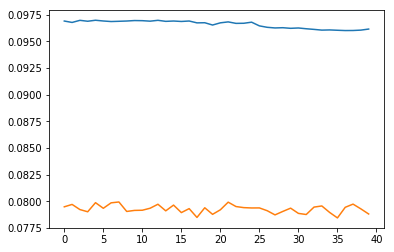

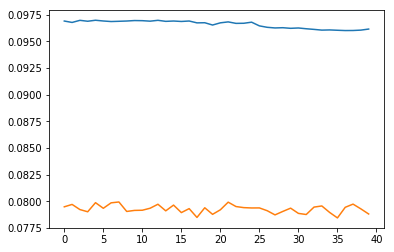

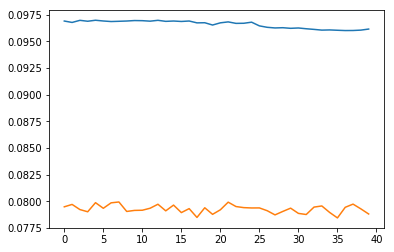

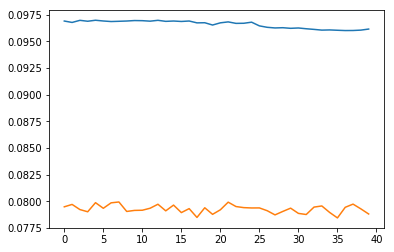

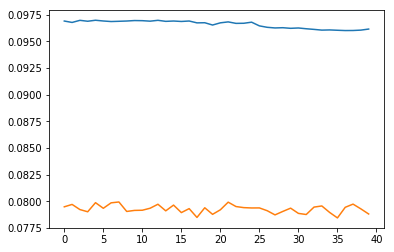

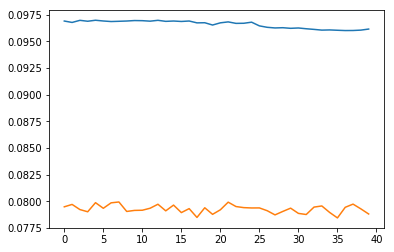

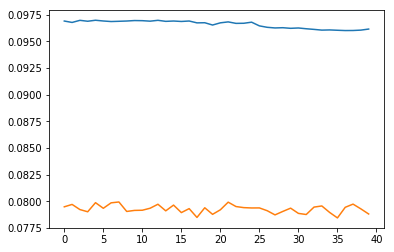

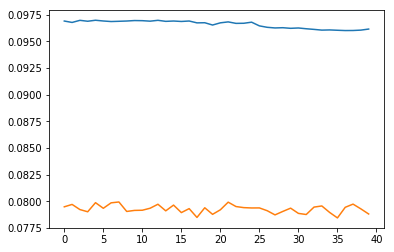

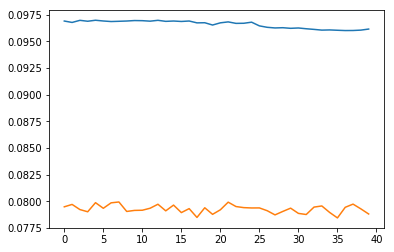

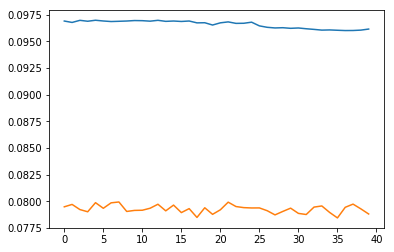

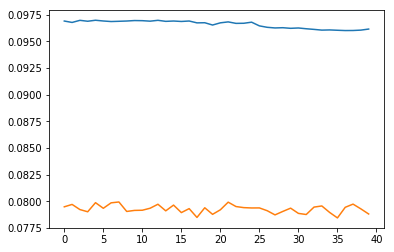

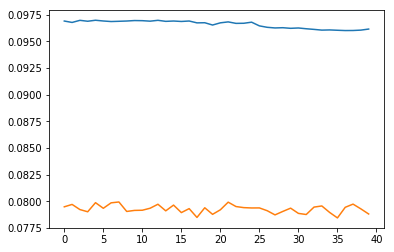

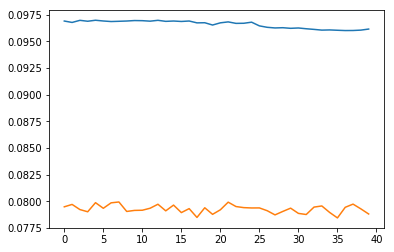

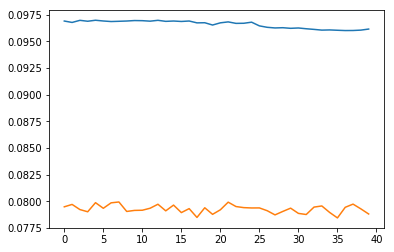

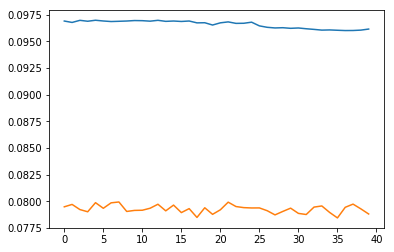

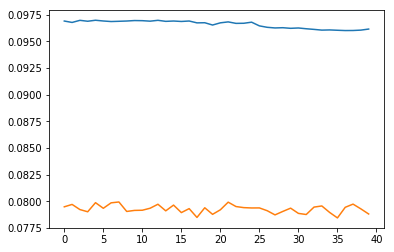

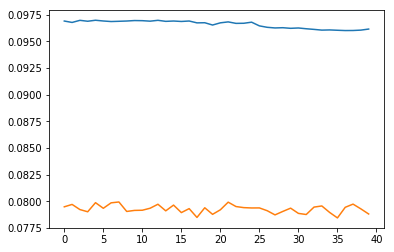

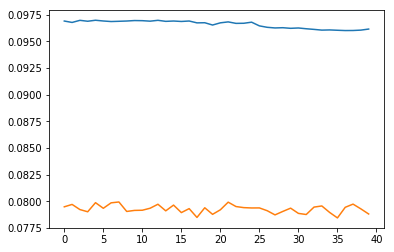

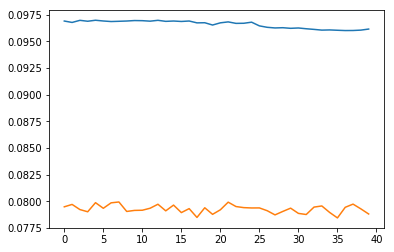

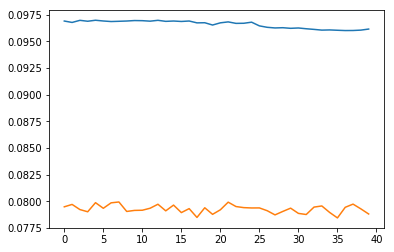

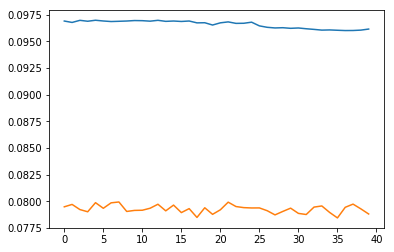

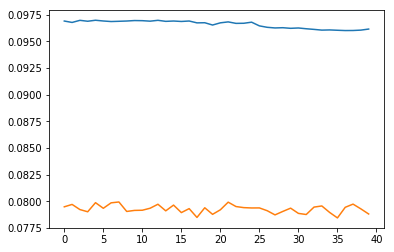

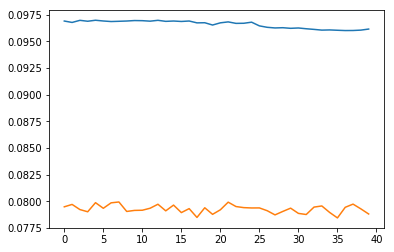

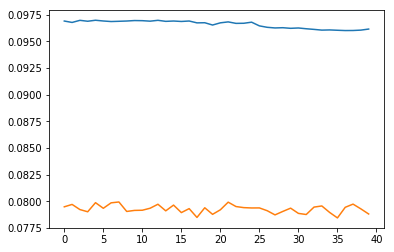

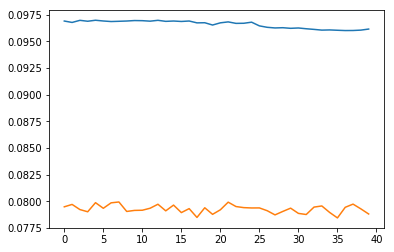

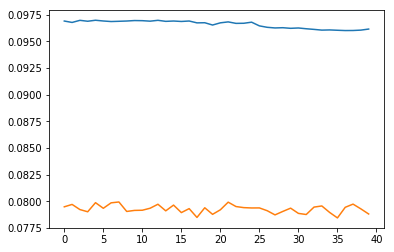

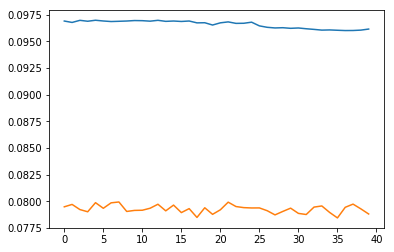

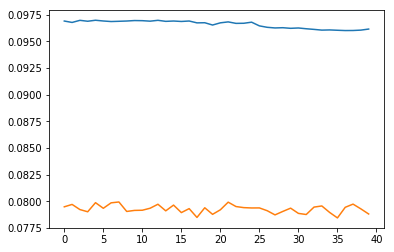

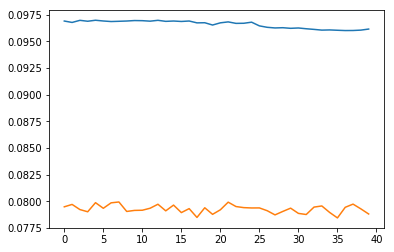

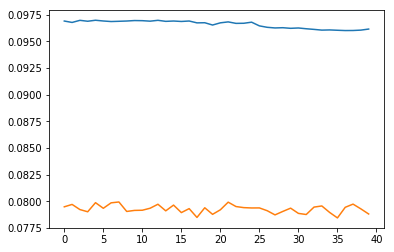

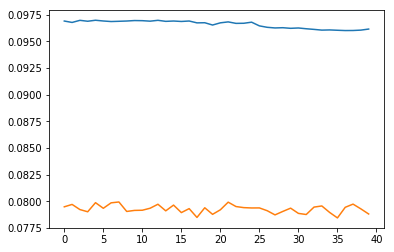

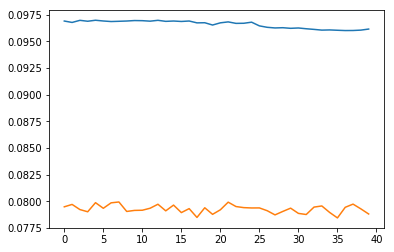

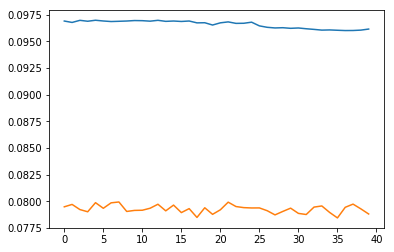

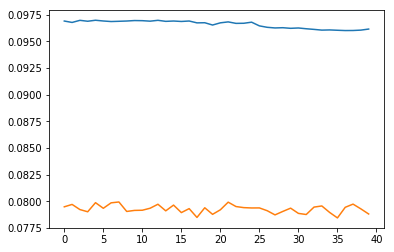

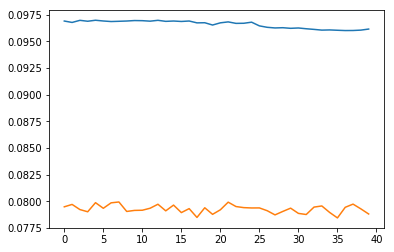

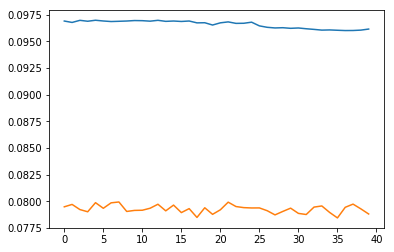

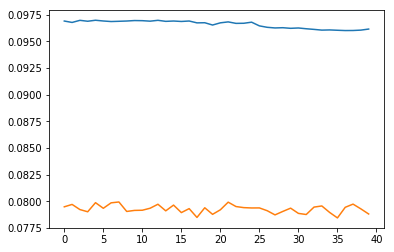

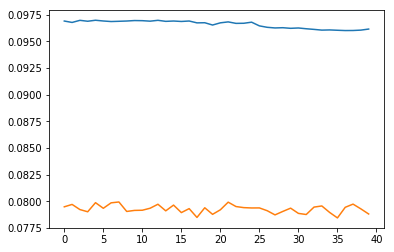

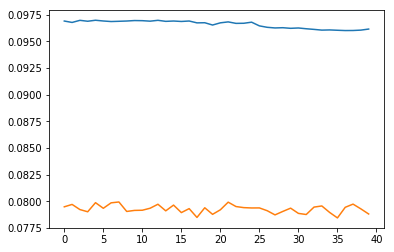

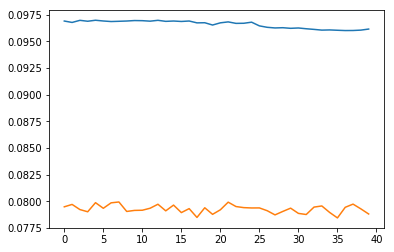

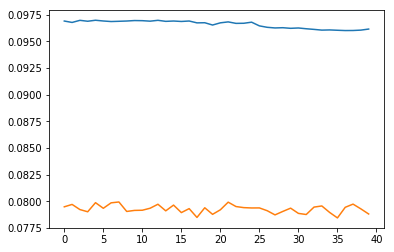

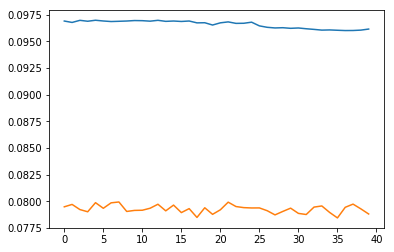

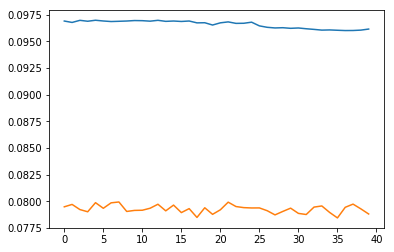

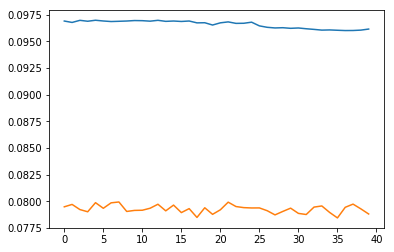

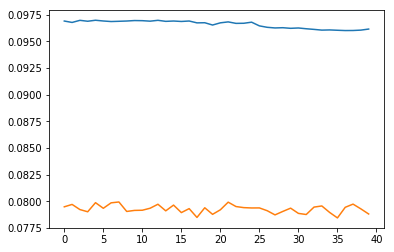

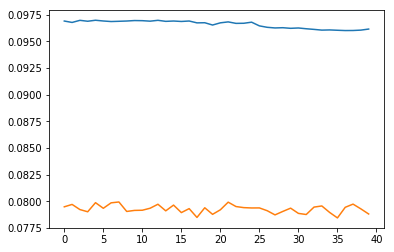

In [57]:
plot_comparison(start_idx=1000, length=1000, train=False)